#### Verilerin yüklenmesi

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('../Datasets/Manipulated Data/train.csv')
test = pd.read_csv('../Datasets/Manipulated Data/test.csv')

train['period'] = pd.to_datetime(train['period'])
test['period'] = pd.to_datetime(test['period'])

train.head(3)

,period,target,gunluk_vaka,toplam_vaka,gunluk_olum,toplam_olum,gasoline_imports,gasoline_exports,crude_imports,crude_exports,...,jet_output,propane_output,residual_fuel_output,conventional_gasoline_spot_price,crude_brent_spot_price,gasoline_future_price1,gasoline_future_price2,gasoline_future_price3,gasoline_future_price4,gasoline_demand
0,2010-10-15,10639,0.0,0.0,0.0,0.0,779,200,8600,33,...,1296,1044,414,2.202,83.11,2.139,2.119,2.128,2.146,9460
1,2010-10-22,10036,0.0,0.0,0.0,0.0,999,200,9463,33,...,1345,1021,473,2.146,81.43,2.077,2.063,2.076,2.097,10639
2,2010-10-29,9886,0.0,0.0,0.0,0.0,871,200,8578,33,...,1309,1032,401,2.122,82.25,2.098,2.072,2.085,2.106,10036


Özellik çıkarım fonksiyonunun oluşturulması


In [2]:
def date_extractor(df, date_col, detailed=0):
    import holidays
    import datetime as dt
    
    # set temporary dataframe
    temp = df.copy()
    temp[date_col] = pd.to_datetime(temp[date_col])
    
    # extract date features
    if detailed == True:
        temp['day_of_year'] = temp[date_col].dt.day
        temp['week'] = temp[date_col].dt.isocalendar().week
        temp['month'] = temp[date_col].dt.month
        temp['year'] = temp[date_col].dt.year
        temp['day_of_week'] = temp[date_col].dt.dayofweek
        temp['day_of_month'] = temp[date_col].dt.day
        temp['quarter'] = temp[date_col].dt.quarter
        temp['is_month_start'] = temp[date_col].dt.is_month_start.astype(int)
        temp['is_month_end'] = temp[date_col].dt.is_month_end.astype(int)
        temp['is_quarter_start'] = temp[date_col].dt.is_quarter_start.astype(int)
        temp['is_quarter_end'] = temp[date_col].dt.is_quarter_end.astype(int)
        temp['is_year_start'] = temp[date_col].dt.is_year_start.astype(int)
        temp['is_year_end'] = temp[date_col].dt.is_year_end.astype(int)
        temp['is_leap_year'] = temp[date_col].dt.is_leap_year.astype(int)
        
        # holidays
        temp['is_holiday'] = temp[date_col].isin(holidays.Turkey()).astype(int)
        temp['is_weekend'] = np.where(temp[date_col].dt.dayofweek < 5, 0, 1).astype(int)
        
        # seasonality
        temp['is_spring'] = np.where(temp[date_col].dt.month.isin([3,4,5]), 1, 0).astype(int)
        temp['is_summer'] = np.where(temp[date_col].dt.month.isin([6,7,8]), 1, 0).astype(int)
        temp['is_autumn'] = np.where(temp[date_col].dt.month.isin([9,10,11]), 1, 0).astype(int)
        temp['is_winter'] = np.where(temp[date_col].dt.month.isin([12,1,2]), 1, 0).astype(int)
        
    else:
        temp['day'] = temp[date_col].dt.day
        temp['week'] = temp[date_col].dt.isocalendar().week
        temp['month'] = temp[date_col].dt.month
        temp['year'] = temp[date_col].dt.year
        
        temp['is_holiday'] = temp[date_col].isin(holidays.Turkey()).astype(int)
        
    return temp

#### Az özellik ile model denemesi

In [3]:
train = date_extractor(train, 'period', detailed=0)
test = date_extractor(test, 'period', detailed=0)

train.drop('period', axis=1, inplace=True)
test.drop('period', axis=1, inplace=True)

train.head(3)

,target,gunluk_vaka,toplam_vaka,gunluk_olum,toplam_olum,gasoline_imports,gasoline_exports,crude_imports,crude_exports,gasoline_stocks,...,gasoline_future_price1,gasoline_future_price2,gasoline_future_price3,gasoline_future_price4,gasoline_demand,day,week,month,year,is_holiday
0,10639,0.0,0.0,0.0,0.0,779,200,8600,33,219329,...,2.139,2.119,2.128,2.146,9460,15,41,10,2010,0
1,10036,0.0,0.0,0.0,0.0,999,200,9463,33,214942,...,2.077,2.063,2.076,2.097,10639,22,42,10,2010,0
2,9886,0.0,0.0,0.0,0.0,871,200,8578,33,212253,...,2.098,2.072,2.085,2.106,10036,29,43,10,2010,0


#### Regresyon Modelleri  

Regresyon modellerinin uygulanabilir olması için belirli varsayımlar vardır:  
1. Normal Dağılım Varsayımı
1. Homoscedasticity (Varyansların homojenliği) varsayımı
1. Bağımsızlık varsayımı
1. Hata terimlerinin normal dağılımı varsayımı  

Yukarıdaki tüm bu varsayımlar sağlanırsa ancak regresyon modeli uygulanabilirdir.  

1. Normal Dağılım Varsayımı Testi:  
Bu varsayım, bağımlı değişkenin normal dağılıma sahip olduğunu varsayar. Normal dağılım testleri, Shapiro-Wilk testi, Anderson-Darling testi, Kolmogorov-Smirnov testi ve grafik yöntemleri (QQ plot gibi) gibi yöntemlerle yapılabilir.  
$H0:$ Verilerin dağılımı ile normal dağılım arasında fark yoktur.

In [13]:
# Shapiro-Wilk normal dağılım testi
from scipy.stats import shapiro
data = train['target'].values
stat, p = shapiro(data)

print('Statistic=%.3f, p=%.3f' % (stat, p))

alpha = 0.05

if p > alpha:
    print('Veriler normal dağılım gösteriyor (H0 reddedilemez)')
else:
    print('Veriler normal dağılım göstermiyor (H0 reddedilir)')

Statistic=0.982, p=0.000
Veriler normal dağılım göstermiyor (H0 reddedilir)


⚠️ **Bağımlı değişken normallik varsayımını sağlamıyor ama yine de son adıma kadar gidip modeli yorumlayacağım.**

2. Homoscedasticity (Varyansların Homojenliği) Varsayımı Testi:  
Bu varsayım, hata terimlerinin varyanslarının sabit olduğunu varsayar. Homoscedasticity testleri, Levene testi, Bartlett testi ve grafik yöntemleri (Residual plot) gibi yöntemlerle yapılabilir.
> Regresyon modelinin residual'ları, tahmin edilen değerlerin gerçek değerlerden çıkarılması ile elde edilir. Yani residual'lar, gerçek değerlerden tahmin edilen değerlerin çıkarılmasıyla elde edilen hataların listesidir.

In [18]:
X = train.drop('target', axis=1)
y = train['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [20]:
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1,1))

In [21]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
lr_preds = lr.predict(X_test)
lr_preds = target_scaler.inverse_transform(lr_preds).reshape(-1,)

In [39]:
residuals = y_test - lr_preds

In [47]:
# Levene's Test
from scipy.stats import levene

stat, p = levene(y_test, lr_preds)

print('Statistik=%.3f, p=%.3f' % (stat, p))

alpha = 0.05

if p > alpha:
    print('Varyanslar homojen (H0 reddedilemez)')
else:
    print('Varyanslar heterojen (H0 reddedilir)')

import plotly.express as px
fig = px.scatter(x=y_test, y=lr_preds, trendline='ols')
fig.show()

Statistik=0.146, p=0.703
Varyanslar homojen (H0 reddedilemez)


3. Bağımsızlık Varsayımı Testi:  
Bu varsayım, gözlemlerin birbirinden bağımsız olduğunu varsayar. Bu varsayım, özellikle zaman serileri verilerinde önemlidir. Bağımsızlık testleri, Durbin-Watson testi ve grafik yöntemleri (Time series plot) gibi yöntemlerle yapılabilir.

In [53]:
# Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson
stat = durbin_watson(residuals)
print('Statistic=%.3f' % (stat))
if stat == 2.0:
    print('Bağımsızlık varsayımı sağlanır (H0 reddedilemez)')
else:
    print('Bağımsızlık varsayımı sağlanmaz (H0 reddedilir)')

Statistic=1.925
Bağımsızlık varsayımı sağlanmaz (H0 reddedilir)


⚠️ **Ancak bu kısımda test istatistiği &asymp; 2.0 için H0 reddedilemez şeklinde yorum da yapılabilir.**

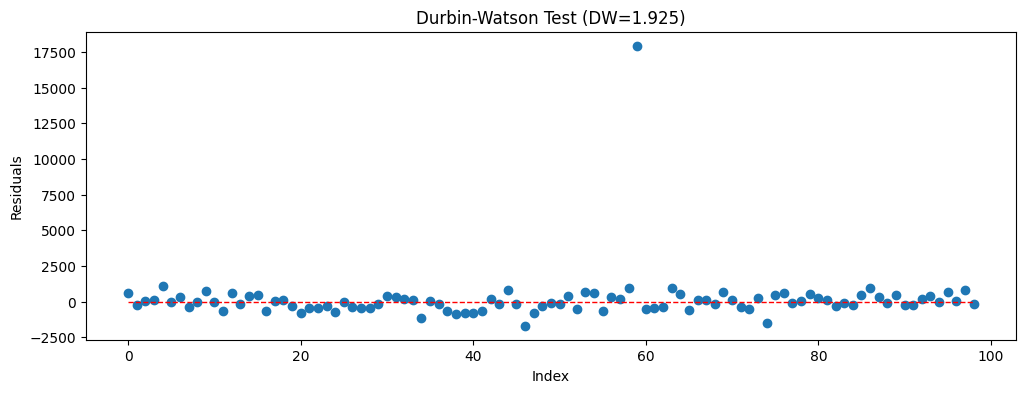

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(range(len(residuals)), residuals)
ax.plot(range(len(residuals)), [0]*len(residuals), 'r--', lw=1)
ax.set_xlabel('Index')
ax.set_ylabel('Residuals')
ax.set_title(f'Durbin-Watson Test (DW={stat:.3f})')
plt.show()

4. Hata terimlerinin normal dağılımı varsayımı:

Statistic=0.283, p=0.000
Veriler normal dağılım göstermiyor (H0 reddedilir)


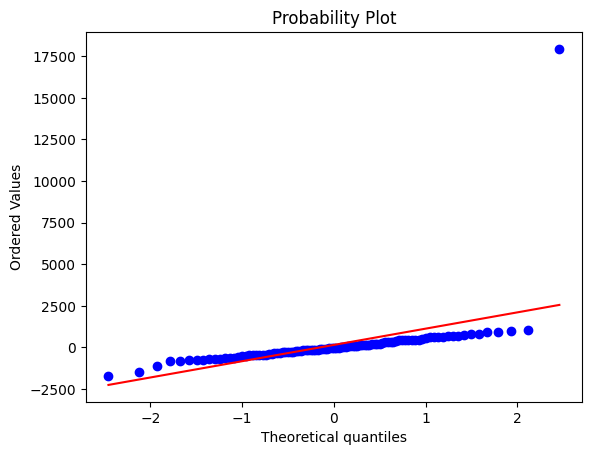

In [55]:
# Normal probability plot of residuals
import scipy.stats as stats
import pylab

stat, p = shapiro(residuals)

print('Statistic=%.3f, p=%.3f' % (stat, p))

alpha = 0.05

if p > alpha:
    print('Veriler normal dağılım gösteriyor (H0 reddedilemez)')
else:
    print('Veriler normal dağılım göstermiyor (H0 reddedilir)')
    
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

Geçerli regresyon modelinin kullanılabilmesi için tüm bu istatistiksel varsayımların sağlanması gerekiyor ki sağlanamadığı için kurulan regresyon modeli çok iyi olsa da kullanılmamalı.

<hr>